# CP 1 - Case Ifood

### Integrantes - RM - Nome
- 556213 João Vitor Pires
- 556984 Tiago Gibo
- 554668 Israel Dalcin
- 555762 Ana Carolina


# Descrição / Objetivo do problema

* O objetivo

O objetivo da equipe é construir um modelo preditivo que produzirá o maior lucro para a próxima campanha de marketing direto, programada para o próximo mês. A nova campanha, sexta, visa a venda de um novo gadget para clientes cadastrados no Banco de Dados da empresa. Para construir o modelo, foi realizada uma campanha piloto envolvendo 2.240 clientes. Os clientes foram selecionados aleatoriamente e contatados por telefone para a aquisição do gadget. Durante os meses seguintes, os clientes que compraram a oferta foram devidamente etiquetados. O custo total da campanha da amostra foi de 6,720MU e a receita gerada pelos clientes que aceitaram a oferta foi de 3,674MU. Globalmente, a campanha teve um lucro de -3,046MU. A taxa de sucesso da campanha foi de 15%. O objetivo da equipe é desenvolver um modelo que preveja o comportamento do cliente e aplicá-lo ao restante da base de clientes. Felizmente, o modelo permitirá que a empresa escolha a dedo os clientes com maior probabilidade de comprar a oferta, deixando de fora os não respondentes, tornando a próxima campanha altamente lucrativa. Além disso, além de maximizar o lucro da campanha, o CMO está interessado em estudar as características dos clientes que desejam comprar o gadget.
Os dados
O conjunto de dados contém características sociodemográficas e firográficas de cerca de 2.240 clientes contatados. Além disso, contém um sinalizador para aqueles clientes que responderam à campanha, comprando o produto.


# Installs

In [62]:
!pip install numba -q
!pip install pycaret -q

# Imports

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns

from pycaret.classification import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_colwidth', 1000)

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [64]:
df = pd.read_csv('data.csv',encoding='utf-8')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [65]:
df_test = pd.read_csv('data.csv',encoding='utf-8')


# Data Cleaning

Drop da feature ID por ser um identificador

In [66]:
df.drop('ID',axis = 1, inplace = True, errors = 'ignore')
df.shape

(2240, 28)

## Features com valores unicos
Verificando a existência de features com valores únicos (devem ser dropadas por não contribuirem para a explicar a variação da feature target)

In [67]:
df.nunique().sort_values()

,0
Z_CostContact,1
Z_Revenue,1
AcceptedCmp4,2
AcceptedCmp5,2
AcceptedCmp1,2
AcceptedCmp3,2
Complain,2
AcceptedCmp2,2
Response,2
Teenhome,3


In [68]:
df.drop(['Z_CostContact','Z_Revenue'],axis=1,inplace = True, errors = 'ignore')

## NaN analysis

In [69]:
df.isna().sum()

,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0
MntFruits,0


Somente a feature Income possui valores nulos.
Analisando as linhas com valores nulos em relação aos valores da feature target

In [70]:
#Distribuição da feature Response entre as amostras com Income = NaN
df[df.Income.isna()].Response.value_counts()

,count
Response,
0,23
1,1


In [71]:
# Proporção de 0 e 1 da feature Response no df completo
df.Response.value_counts(normalize = True)

,proportion
Response,
0,0.850893
1,0.149107


In [72]:
print('% amostras com NaN: ',np.round((df.Income.isna().sum()/len(df))*100,2))
print('% amostras com NaN e Response = 1: ',
      np.round((( len(df[(df.Income.isna()) & (df.Response == 1)]) / len(df))*100),2))

% amostras com NaN:  1.07
% amostras com NaN e Response = 1:  0.04


Dado que as 24 linhas com valores Nan representam 1% do dataset total, e que entre as 24 linhas com Income == Nan somente uma apresentou Response == 1 (0.04%), as 24 linhas serão dropadas

In [73]:
print('Shape antes do dropna: ',df.shape[0])
df.dropna(axis=0,inplace = True)
print('Shape após o dropna: ',df.shape[0])

Shape antes do dropna:  2240
Shape após o dropna:  2216


## Ajuste do dtypes

In [74]:
df = df.convert_dtypes()
df.Dt_Customer = pd.to_datetime(df.Dt_Customer)
df.Response = df.Response.astype('bool')
df.dtypes

,0
Year_Birth,Int64
Education,string[python]
Marital_Status,string[python]
Income,Int64
Kidhome,Int64
Teenhome,Int64
Dt_Customer,datetime64[ns]
Recency,Int64
MntWines,Int64
MntFruits,Int64


# Feature Engineering

## Idade dos clientes

In [75]:
from datetime import datetime
ano_atual = datetime.now().year
df['Age'] = ano_atual - df.Year_Birth
df.drop('Year_Birth',axis = 1, errors = 'ignore', inplace = True)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,Graduation,Single,58138,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,True,68
1,Graduation,Single,46344,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,False,71
2,Graduation,Together,71613,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,False,60
3,Graduation,Together,26646,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,False,41
4,PhD,Married,58293,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,False,44


## Tratamento do Income

In [76]:
df = df[df['Income'] < 200000]
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,Graduation,Single,58138,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,True,68
1,Graduation,Single,46344,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,False,71
2,Graduation,Together,71613,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,False,60
3,Graduation,Together,26646,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,False,41
4,PhD,Married,58293,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,False,44


### Definindo faixa de renda

In [77]:
df['Income'].min()

1730

In [78]:
df['Income'].max()

162397

## Tempo como cliente

In [79]:
dt = datetime.now().date()
df['Time_Customer'] = dt - pd.to_datetime(df['Dt_Customer']).dt.date
df['Time_Customer'] = df['Time_Customer'] / np.timedelta64(365, 'D')
print(df[['Dt_Customer','Time_Customer']].head())
df.drop('Dt_Customer',axis = 1, inplace = True)

  Dt_Customer  Time_Customer
0  2012-09-04      12.613699
1  2014-03-08      11.106849
2  2013-08-21      11.652055
3  2014-02-10      11.178082
4  2014-01-19      11.238356


### Removendo valores incoerentes com a variável Marital_Status

In [80]:
index_to_drop = df[(df['Marital_Status'] =='YOLO') | (df['Marital_Status'] =='Absurd') | (df['Marital_Status'] =='absurd') | (df['Marital_Status'] == 'Alone')].index
df.drop(index_to_drop,inplace = True)
df = df.reset_index(drop = True)
df.Marital_Status.value_counts()

,count
Marital_Status,
Married,857
Together,572
Single,471
Divorced,232
Widow,76


In [81]:
df.rename(columns={'Response':'z_Response'},inplace = True)
cols = df.columns.sort_values()
df = df[cols]
df.rename(columns={'z_Response':'Response'},inplace = True)

df.columns

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Education', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome',
       'Time_Customer', 'Response'],
      dtype='object')

# Preparação do dataset para Modelagem


## Train Test Validation Split

In [82]:
# sample 5% of data to be used as unseen data
df_train_test = df.sample(frac=0.95, random_state=123)
df_valid = df.drop(df_train_test.index)
df_train_test.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
# print the revised shape
print('Data for Modeling: ' + str(df_train_test.shape))
print('Unseen Data For Predictions: ' + str(df_valid.shape))

Data for Modeling: (2098, 26)
Unseen Data For Predictions: (110, 26)


# Auto ML - PYCARET

**Para o problema de negócio em questão, a métrica Precision é a mais relevante.**

## Setup

In [83]:
s = setup(data = df_train_test,
          target = 'Response',
          fix_imbalance = True,
          remove_outliers = True,
          categorical_features = ['Education', 'Marital_Status'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,Response
2,Target type,Binary
3,Original data shape,"(2098, 26)"
4,Transformed data shape,"(3058, 34)"
5,Transformed train set shape,"(2428, 34)"
6,Transformed test set shape,"(630, 34)"
7,Numeric features,23
8,Categorical features,2
9,Preprocess,True


In [84]:
# check available models
#has to be called necessary only after having defined a setup.
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## Comparativo entre Modelos

In [85]:
best_model = compare_models(sort = 'auc', errors = 'raise')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8263,0.9039,0.8277,0.4637,0.5903,0.4923,0.5288,0.2790
lda,Linear Discriminant Analysis,0.8256,0.9038,0.8277,0.4624,0.5893,0.4909,0.5276,0.2280
gbc,Gradient Boosting Classifier,0.8883,0.8926,0.4982,0.6757,0.5658,0.5044,0.5164,1.1000
lightgbm,Light Gradient Boosting Machine,0.8774,0.8844,0.4389,0.6475,0.5156,0.4489,0.4643,1.2830
ada,Ada Boost Classifier,0.8692,0.8783,0.5968,0.5719,0.5795,0.5028,0.5057,0.5280
rf,Random Forest Classifier,0.8733,0.8776,0.3528,0.6532,0.4510,0.3875,0.4142,0.5810
xgboost,Extreme Gradient Boosting,0.8740,0.8772,0.4615,0.6277,0.5221,0.4522,0.4648,0.5810
et,Extra Trees Classifier,0.8788,0.8721,0.4024,0.6731,0.4960,0.4327,0.4551,0.4360
qda,Quadratic Discriminant Analysis,0.2419,0.8231,0.9777,0.1633,0.2797,0.0293,0.1068,0.2160
lr,Logistic Regression,0.7493,0.8128,0.7105,0.3440,0.4619,0.3248,0.3617,1.8170


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [86]:
print(best_model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)


## Análise do Modelo

In [87]:
#evaluate model
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

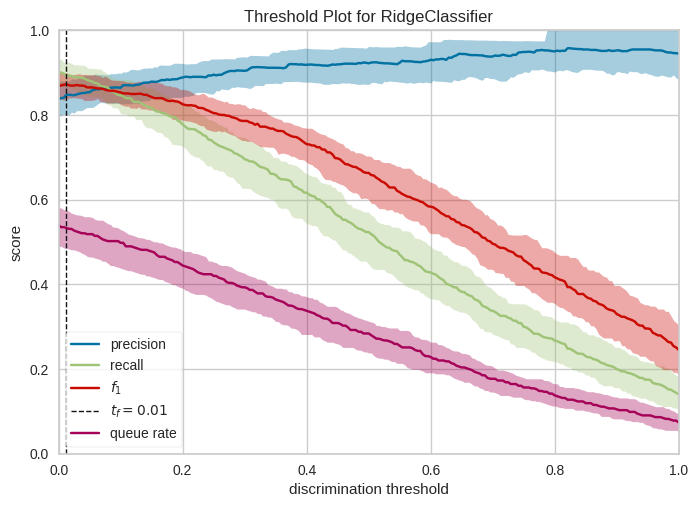

In [88]:
#plot model - treshold
plot_model(best_model, plot = 'threshold')

In [89]:
#plot model - auc
#plot_model(best_model, plot = 'auc')

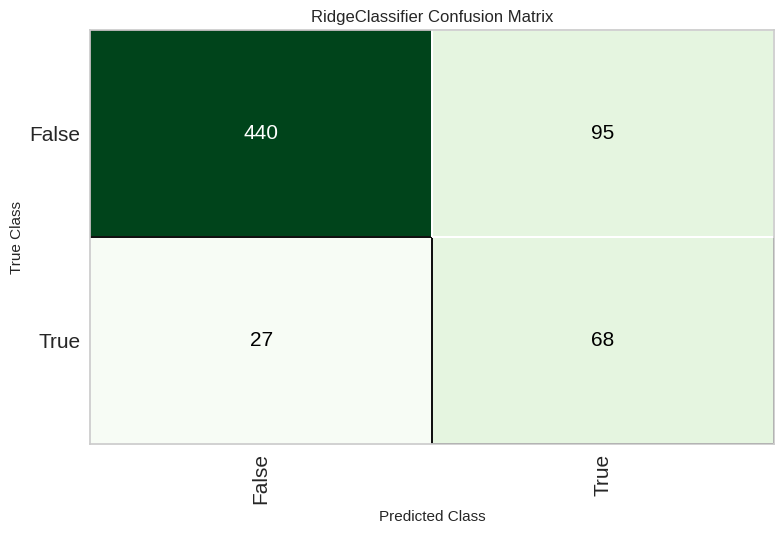

In [90]:
#plot model - confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

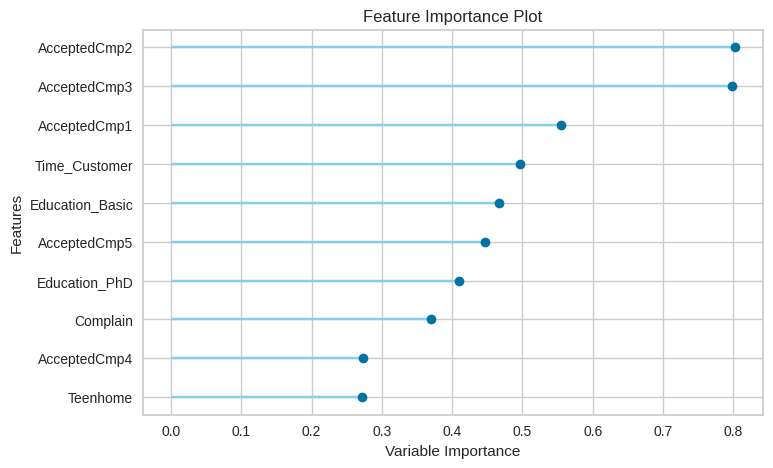

In [91]:
#plot model - feature
plot_model(best_model, plot = 'feature')

In [92]:
#predict model - raw score
predict_model(best_model, raw_score= True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8063,0.7691,0.7158,0.4172,0.5271,0.4158,0.4398


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label
1866,1,0,0,0,1,79,0,PhD,82800,0,...,6,1,12,7,3,23,0,12.391781,True,1
1780,0,0,0,0,0,57,0,Master,29543,2,...,1,2,2,3,7,47,0,11.041096,False,0
1943,0,0,0,0,0,75,0,PhD,59292,0,...,5,2,8,3,3,71,1,11.841096,False,0
1669,0,0,1,0,0,55,0,PhD,38097,1,...,2,4,2,3,7,70,1,12.501369,True,1
1226,0,0,0,0,0,74,0,Master,39767,0,...,1,2,7,7,8,18,0,11.736986,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0,0,0,0,0,52,0,2n Cycle,31163,1,...,0,1,3,1,6,54,0,11.169863,False,0
1923,0,0,0,0,0,53,0,Graduation,26290,1,...,0,4,4,2,6,49,1,12.257534,False,0
1527,0,0,0,0,0,66,0,2n Cycle,59052,0,...,1,3,7,7,5,29,1,11.410959,False,0
649,0,0,0,0,0,68,0,PhD,41437,1,...,0,1,3,1,7,5,1,12.564384,False,1


* Outros tipos de plot:
https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.plot_model

## Criando um Modelo

In [93]:
#create model rf
mdl_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8912,0.9311,0.3913,0.8182,0.5294,0.4764,0.5180
1,0.9048,0.9380,0.5909,0.7222,0.6500,0.5955,0.5995
2,0.8571,0.8818,0.3182,0.5385,0.4000,0.3250,0.3395
3,0.8639,0.8058,0.3182,0.5833,0.4118,0.3423,0.3624
4,0.8707,0.8424,0.2273,0.7143,0.3448,0.2938,0.3539
5,0.8571,0.8616,0.3182,0.5385,0.4000,0.3250,0.3395
6,0.8776,0.8902,0.2727,0.7500,0.4000,0.3480,0.4037
7,0.8571,0.8653,0.3636,0.5333,0.4324,0.3540,0.3626
8,0.8904,0.8864,0.4091,0.7500,0.5294,0.4734,0.5013


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Tuning dos Hiperparâmetros

### RF

In [94]:
tuned_rf = tune_model(mdl_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9184,0.9411,0.6522,0.7895,0.7143,0.6672,0.6713
1,0.9252,0.9305,0.7727,0.7391,0.7556,0.7114,0.7116
2,0.8503,0.8615,0.4545,0.5000,0.4762,0.3891,0.3897
3,0.8707,0.8376,0.4091,0.6000,0.4865,0.4156,0.4255
4,0.8707,0.8702,0.5000,0.5789,0.5366,0.4620,0.4636
5,0.8299,0.8247,0.3182,0.4118,0.3590,0.2628,0.2657
6,0.8844,0.8658,0.4091,0.6923,0.5143,0.4535,0.4738
7,0.8435,0.8480,0.4091,0.4737,0.4390,0.3487,0.3499
8,0.9110,0.8776,0.5455,0.8000,0.6486,0.5997,0.6142


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [95]:
#predict rf
#mdl_rf com e sem tuning apresentaram AUC e desvio padrao (STD) praticamente iguais.
predict_model(mdl_rf, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8873,0.8953,0.4211,0.7143,0.5298,0.4706,0.4918


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
1866,1,0,0,0,1,79,0,PhD,82800,0,...,12,7,3,23,0,12.391781,True,1,0.1000,0.9000
1780,0,0,0,0,0,57,0,Master,29543,2,...,2,3,7,47,0,11.041096,False,0,0.7200,0.2800
1943,0,0,0,0,0,75,0,PhD,59292,0,...,8,3,3,71,1,11.841096,False,0,0.9600,0.0400
1669,0,0,1,0,0,55,0,PhD,38097,1,...,2,3,7,70,1,12.501369,True,0,0.5000,0.5000
1226,0,0,0,0,0,74,0,Master,39767,0,...,7,7,8,18,0,11.736986,False,0,0.6200,0.3800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0,0,0,0,0,52,0,2n Cycle,31163,1,...,3,1,6,54,0,11.169863,False,0,1.0000,0.0000
1923,0,0,0,0,0,53,0,Graduation,26290,1,...,4,2,6,49,1,12.257534,False,0,0.9200,0.0800
1527,0,0,0,0,0,66,0,2n Cycle,59052,0,...,7,7,5,29,1,11.410959,False,0,0.9200,0.0800
649,0,0,0,0,0,68,0,PhD,41437,1,...,3,1,7,5,1,12.564384,False,0,0.9567,0.0433


In [96]:
print(mdl_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [97]:
print(tuned_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, monotonic_cst=None,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


In [98]:
#predict rf
predict_model(tuned_rf, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8714,0.8522,0.4947,0.5875,0.5371,0.4631,0.4654


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
1866,1,0,0,0,1,79,0,PhD,82800,0,...,12,7,3,23,0,12.391781,True,1,0.1859,0.8141
1780,0,0,0,0,0,57,0,Master,29543,2,...,2,3,7,47,0,11.041096,False,0,0.6746,0.3254
1943,0,0,0,0,0,75,0,PhD,59292,0,...,8,3,3,71,1,11.841096,False,0,0.7672,0.2328
1669,0,0,1,0,0,55,0,PhD,38097,1,...,2,3,7,70,1,12.501369,True,1,0.3679,0.6321
1226,0,0,0,0,0,74,0,Master,39767,0,...,7,7,8,18,0,11.736986,False,0,0.6265,0.3735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0,0,0,0,0,52,0,2n Cycle,31163,1,...,3,1,6,54,0,11.169863,False,0,0.9279,0.0721
1923,0,0,0,0,0,53,0,Graduation,26290,1,...,4,2,6,49,1,12.257534,False,0,0.8360,0.1640
1527,0,0,0,0,0,66,0,2n Cycle,59052,0,...,7,7,5,29,1,11.410959,False,0,0.7321,0.2679
649,0,0,0,0,0,68,0,PhD,41437,1,...,3,1,7,5,1,12.564384,False,0,0.8652,0.1348


## AUC Plot

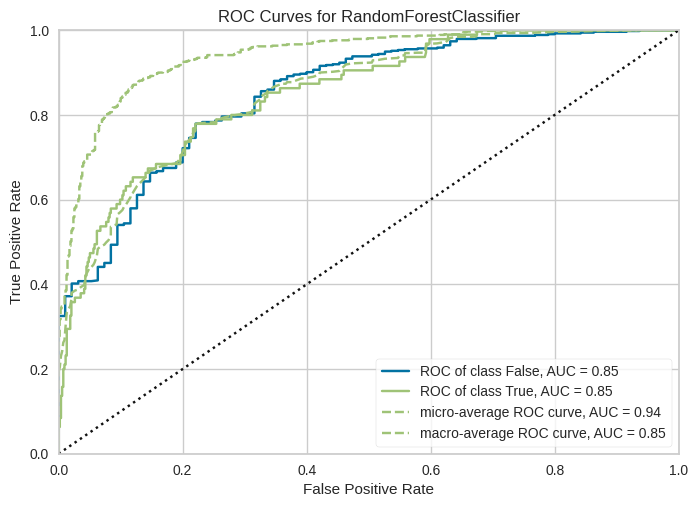

In [99]:
#auc
plot_model(tuned_rf, plot = 'auc')

## Feature Importance

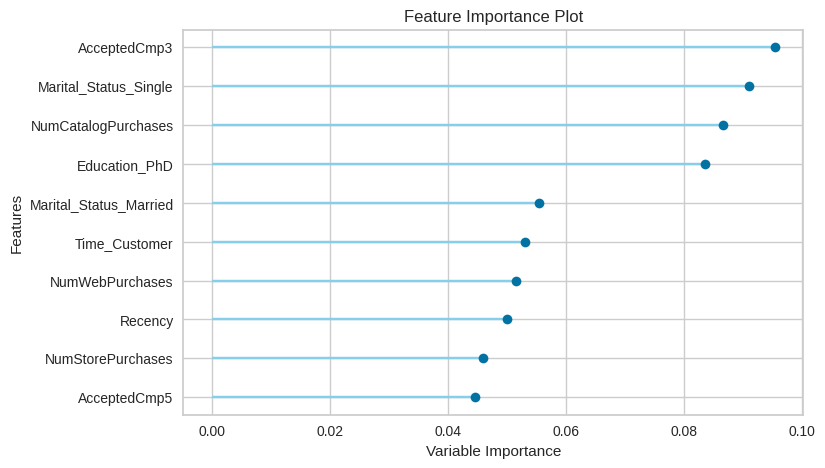

In [100]:
#feature
plot_model(tuned_rf, plot = 'feature')

## Matriz de Confusão

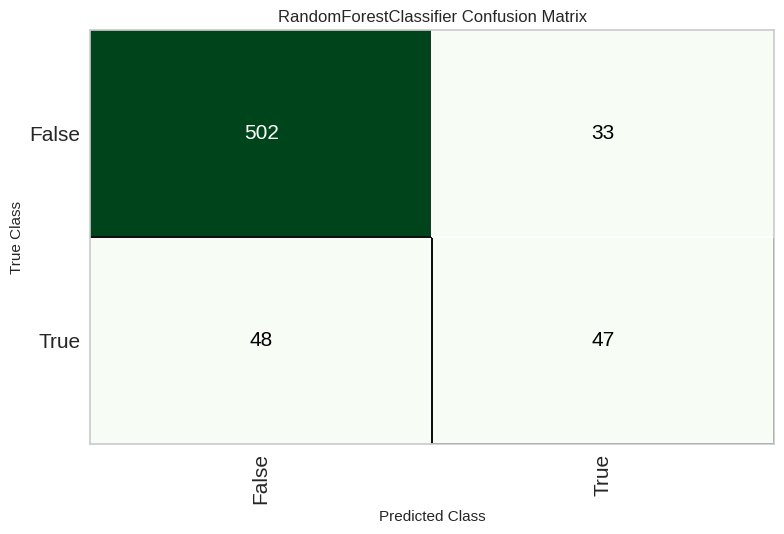

In [101]:
#confusion matrix
plot_model(tuned_rf, plot = 'confusion_matrix')

# Início do CP

## Feature engineering

* Fizemos um feature engineering transformando a coluna de "Education" em um valor ordinal, para que possamos ter pesos diferentes dependendo do nível de escolaridade do cliente.
* Além disso, também transformamos a coluna de "Marital status" em dummys.

In [102]:
df_cp = df.copy()

### Education

In [103]:
# Dicionário de mapeamento ordinal
education_map = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}

# Aplicando o mapeamento ao DataFrame
df_cp['Education'] = df_cp['Education'].map(education_map)

## Preparando os dados para modelagem

### Train Test split

In [104]:
# sample 5% of data to be used as unseen data
df_train_test = df_cp.sample(frac=0.95, random_state=123)
df_valid = df_cp.drop(df_train_test.index)
df_train_test.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
# print the revised shape
print('Data for Modeling: ' + str(df_train_test.shape))
print('Unseen Data For Predictions: ' + str(df_valid.shape))

Data for Modeling: (2098, 26)
Unseen Data For Predictions: (110, 26)


### Setup

In [105]:
s_cp = setup(data = df_train_test,
          target = 'Response',
          fix_imbalance = True,
          remove_outliers = True,
          categorical_features = ['Marital_Status'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,Response
2,Target type,Binary
3,Original data shape,"(2098, 26)"
4,Transformed data shape,"(3074, 30)"
5,Transformed train set shape,"(2444, 30)"
6,Transformed test set shape,"(630, 30)"
7,Numeric features,24
8,Categorical features,1
9,Preprocess,True


## Comparando os modelos

In [106]:
cp_best_model = compare_models(sort = 'auc', errors = 'raise')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8229,0.9076,0.8322,0.4592,0.5882,0.4888,0.5263,0.2010
lda,Linear Discriminant Analysis,0.8229,0.9076,0.8277,0.4582,0.5862,0.4866,0.5236,0.2520
gbc,Gradient Boosting Classifier,0.8822,0.8928,0.4753,0.6566,0.5439,0.4791,0.4914,1.0660
lightgbm,Light Gradient Boosting Machine,0.8842,0.8873,0.4433,0.6873,0.5287,0.4675,0.4871,1.0140
xgboost,Extreme Gradient Boosting,0.8761,0.8846,0.4387,0.6371,0.5079,0.4412,0.4571,0.4080
ada,Ada Boost Classifier,0.8665,0.8738,0.5792,0.5670,0.5644,0.4870,0.4920,0.4270
rf,Random Forest Classifier,0.8733,0.8726,0.3573,0.6431,0.4481,0.3857,0.4113,0.7300
et,Extra Trees Classifier,0.8733,0.8669,0.3792,0.6329,0.4643,0.3995,0.4207,0.4710
qda,Quadratic Discriminant Analysis,0.2009,0.8426,0.9911,0.1576,0.2719,0.0164,0.0827,0.2070
lr,Logistic Regression,0.7534,0.8156,0.7332,0.3523,0.4750,0.3403,0.3790,0.4800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [107]:
evaluate_model(cp_best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Tunning model

## Ridge classifier

In [108]:
mdl_ridge = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9425,0.9130,0.5250,0.6667,0.5840,0.6202
1,0.7415,0.9298,0.9091,0.3571,0.5128,0.3795,0.4563
2,0.8163,0.8800,0.6818,0.4286,0.5263,0.4197,0.4371
3,0.8163,0.8820,0.8182,0.4390,0.5714,0.4677,0.5045
4,0.8095,0.9160,0.9091,0.4348,0.5882,0.4837,0.5394
5,0.8367,0.8633,0.8636,0.4750,0.6129,0.5203,0.5576
6,0.8776,0.9284,0.7727,0.5667,0.6538,0.5816,0.5919
7,0.8027,0.9000,0.8182,0.4186,0.5538,0.4437,0.4848
8,0.8356,0.9128,0.7273,0.4706,0.5714,0.4754,0.4927


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [109]:
tuned_ridge = tune_model(mdl_ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9390,0.9130,0.5250,0.6667,0.5840,0.6202
1,0.7551,0.9309,0.9091,0.3704,0.5263,0.3984,0.4714
2,0.8231,0.8847,0.6818,0.4412,0.5357,0.4326,0.4482
3,0.8163,0.8842,0.8182,0.4390,0.5714,0.4677,0.5045
4,0.8095,0.9131,0.9091,0.4348,0.5882,0.4837,0.5394
5,0.8299,0.8629,0.8636,0.4634,0.6032,0.5072,0.5470
6,0.8844,0.9280,0.8182,0.5806,0.6792,0.6112,0.6245
7,0.8027,0.8982,0.8182,0.4186,0.5538,0.4437,0.4848
8,0.8356,0.9124,0.7273,0.4706,0.5714,0.4754,0.4927


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


## LDA

In [110]:
mdl_lda = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8503,0.9428,0.9130,0.5122,0.6562,0.5701,0.6090
1,0.7483,0.9295,0.9091,0.3636,0.5195,0.3888,0.4638
2,0.8163,0.8789,0.6818,0.4286,0.5263,0.4197,0.4371
3,0.8163,0.8820,0.8182,0.4390,0.5714,0.4677,0.5045
4,0.8095,0.9167,0.9091,0.4348,0.5882,0.4837,0.5394
5,0.8367,0.8629,0.8636,0.4750,0.6129,0.5203,0.5576
6,0.8707,0.9284,0.7273,0.5517,0.6275,0.5510,0.5587
7,0.8027,0.9004,0.8182,0.4186,0.5538,0.4437,0.4848
8,0.8356,0.9128,0.7273,0.4706,0.5714,0.4754,0.4927


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [111]:
tuned_lda = tune_model(mdl_lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8503,0.9428,0.9130,0.5122,0.6562,0.5701,0.6090
1,0.7483,0.9298,0.9091,0.3636,0.5195,0.3888,0.4638
2,0.8231,0.8822,0.6818,0.4412,0.5357,0.4326,0.4482
3,0.8163,0.8835,0.8182,0.4390,0.5714,0.4677,0.5045
4,0.8095,0.9153,0.9091,0.4348,0.5882,0.4837,0.5394
5,0.8299,0.8593,0.8636,0.4634,0.6032,0.5072,0.5470
6,0.8776,0.9309,0.7727,0.5667,0.6538,0.5816,0.5919
7,0.7959,0.8996,0.8182,0.4091,0.5455,0.4321,0.4753
8,0.8356,0.9146,0.7273,0.4706,0.5714,0.4754,0.4927


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## LightGBM

In [112]:
mdl_lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8707,0.9025,0.4783,0.6111,0.5366,0.4628,0.4675
1,0.9320,0.9600,0.7727,0.7727,0.7727,0.7327,0.7327
2,0.8639,0.8560,0.2727,0.6000,0.3750,0.3105,0.3411
3,0.8776,0.8351,0.3636,0.6667,0.4706,0.4081,0.4321
4,0.8639,0.8796,0.3636,0.5714,0.4444,0.3713,0.3836
5,0.8980,0.8858,0.4545,0.7692,0.5714,0.5178,0.5410
6,0.9048,0.9258,0.5000,0.7857,0.6111,0.5599,0.5785
7,0.8299,0.8396,0.3636,0.4211,0.3902,0.2920,0.2931
8,0.8904,0.8688,0.3182,0.8750,0.4667,0.4201,0.4875


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [113]:
tuned_lgbm = tune_model(mdl_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8639,0.9187,0.4783,0.5789,0.5238,0.4453,0.4480
1,0.9184,0.9596,0.7727,0.7083,0.7391,0.6909,0.6918
2,0.8844,0.8600,0.3636,0.7273,0.4848,0.4278,0.4605
3,0.8776,0.8675,0.5000,0.6111,0.5500,0.4800,0.4832
4,0.8503,0.8745,0.4545,0.5000,0.4762,0.3891,0.3897
5,0.8776,0.8724,0.4091,0.6429,0.5000,0.4341,0.4485
6,0.8980,0.9105,0.4091,0.8182,0.5455,0.4951,0.5330
7,0.8639,0.8298,0.5000,0.5500,0.5238,0.4447,0.4453
8,0.9110,0.8842,0.4545,0.9091,0.6061,0.5621,0.6051


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


## Save Model

In [114]:
save_model(mdl_lda, '/content/pickle_rf_pycaret2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AcceptedCmp1', 'AcceptedCmp2',
                                              'AcceptedCmp3', 'AcceptedCmp4',
                                              'AcceptedCmp5', 'Age', 'Complain',
                                              'Education', 'Income', 'Kidhome',
                                              'MntFishProducts', 'MntFruits',
                                              'MntGoldProds', 'MntMeatProducts',
                                              'MntSweetProducts', 'MntWines',
                                              'NumCatalogPurchases',
                                              'NumD...
                                                                threshold=0.05))),
                 ('balance',
                  TransformerWrapper(exclude=None, include=None,
               

In [115]:
cols_x_test = get_config(variable="X_test").columns
cols_x_test

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Education', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome',
       'Time_Customer'],
      dtype='object')

In [116]:
df_valid.drop('Response', axis = 1).to_csv('Xtest.csv', index = False)

In [117]:
df_valid

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response
0,0,0,0,0,0,41,0,3,26646,1,...,11,0,2,4,2,6,26,0,11.178082,False
1,0,0,0,0,0,79,0,3,37760,0,...,84,1,2,6,4,7,20,0,12.624658,False
2,0,0,0,0,0,40,0,4,20559,1,...,13,0,2,3,2,8,88,0,12.095890,False
3,0,0,0,0,0,68,0,3,65486,0,...,245,2,1,10,4,2,29,1,10.928767,False
4,0,0,0,0,0,61,0,4,79143,0,...,650,9,1,13,6,3,2,0,12.679452,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,1,26487,1,...,2,1,3,3,2,5,23,0,11.906849,False
106,0,0,0,0,0,42,0,4,89616,0,...,671,5,1,12,7,2,36,0,12.136986,True
107,0,0,0,0,0,54,0,3,40851,1,...,23,1,1,2,1,7,63,1,12.147945,False
108,0,0,0,0,0,75,0,4,38054,1,...,23,0,2,3,2,7,24,1,10.958904,False


# Conclusão

## Encontramos alguns problemas na instalação de algumas bibliotecas, devido a divergências entre suas versões. Além disso, foi necessário corrigir métodos relacionados à manipulação de datas, pois estavam resultando em erros no código.
## Escolhemos o "Linear Discriminant Analysis" como nosso melhor modelo. De acordo com o critério de avaliação, que tinha como alvo a melhor AUC, o LDA foi o que se destacou, apesar das outras métricas estarem um pouco abaixo do Ridge Classifier.
## O modelo apresentou uma AUC melhor, mas não muito distante daquela obtida pelo modelo do professor, além disso, foi menos consistente nas demais métricas. Acreditamos que, devido à feature engineering aplicada, o modelo desenvolveu um entendimento diferente sobre os dados.